# Digital Turn Without Digital Methods? Mapping the Journey of Journalism Studies 


**Abstract**

Recent years have seen a growing diversity in the field of journalism studies, which is primarily 
ascribed to digital transformation in the contemporary context. Analyzing 6770 publications 
from the five major journalism journals—Journalism, Journalism & Mass Communication 
Quarterly, Journalism Practice, Journalism Studies, and Digital Journalism—over the years 
1995-2022, we find new evidence that the digital turn is highly visible in journalism studies. 
Using document co-citation analysis, first, we have identified many distinct and coherent, yet 
loosely integrated, research clusters that focus on different journalistic topics, i.e., specialties.
Second, we find that digital journalism research has not only been integrated into the research 
agendas within the field but also formed stand-alone and distinct research clusters. We further 
show that field structure has developed over the years in response to digital transformation, yet
digital and computational methods still remain in the stark minority compared to the more 
traditional methods. Overall, our results suggest that (digital) journalism studies could 
potentially benefit from novel inter-cluster communications and methodological innovations

In [1]:
%matplotlib inline

import pandas as pd
import os
import glob 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import rcParams
import pandas as pd
import random
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
from itertools import combinations
import networkx as nx
import infomap
import networkx.algorithms.community as nx_comm
from collections import defaultdict
from IPython.display import Markdown as md
import igraph
import leidenalg
import colorsys

<hr>

## Data source
❓ How did we sample journalism research articles ❓
> We selected relevant articles by considering the journals they were published in, which included
> 1. Digital Journalism
> 2. Journalism & Mass Communication Quarterly 
> 3. Journalism Practice
> 4. Journalism Studies
> 5. Journalism: Theory, Practice & Criticism.

👉 Then, I scraped all the available **papers** from these journals from [OpenAlex](https://docs.openalex.org/api-entities/venues) and identified all the **citation pairs**. 
Additionally, I collected the papers' **first published date**, i.e., the earliest date between the issue and online dates, and **abstracts** from web pages associated with the papers' digital object identifiers (DOI).



In [2]:
data=pd.read_csv('../data/dj_corpus_clean.csv')
date=pd.read_csv("../data/mined_dates.csv")

### Data Cleaning 
> 1. remove `1330` book review artcles
> 2. remove `69` Newly released
> 3. remove `8` Corrections
> 4. remove `97` editorial comments and notes 
> 5. remove `111` information for contributors
> 6. remove `9` corrigendum 
> 7. remove `4` commentaries and `2` letters

after removing a total of 1630 articles



In [3]:
## data cleaning 
data=data[data.publication_year>1948].reset_index(drop=True)
data["book_review"]=data.title.apply(lambda x:1 if "book review" in x.lower() or "reviews"== x.lower() or "booknote" in x.lower() or "bookmark" in x.lower() else 0)
data["newly_released"]=data.title.apply(lambda x:1 if "newly released" == x.lower() else 0)
data["correction"]=data.title.apply(lambda x:1 if "correction" == x.lower() else 0)
data['editorial']=data.title.apply(lambda x:1 if 'editorial'== x.lower() or "editorial note" in x.lower() or "editorial comment" in x.lower() or "editorial: " in x.lower() or ("editor" in x.lower() and "note" in x.lower()) else 0)
data['contributor_notes']=data.title.apply(lambda x:1 if 'notes on contributor' in x.lower() or 'information for contributor' in x.lower() or "contributors" == x.lower() else 0)
data['corrigendum']=data.title.apply(lambda x: 1 if "corrigendum" in x.lower() else 0)
data['letters']=data.title.apply(lambda x: 1 if "letters" ==x.lower() else 0)
data['commentary']=data.title.apply(lambda x: 1 if "commentary:" in x.lower() else 0)
data['others']=data.book_review+data.commentary+data.newly_released+data.correction+data.editorial+data.contributor_notes+ data.corrigendum+data.letters

In [4]:
data=data[data.others==0].reset_index(drop=True)
md('Total number of papers retained in the analysis: {}'.format( len(data)))

Total number of papers retained in the analysis: 6770

In [5]:
## the earlist dates
data.doi=data.doi.str.lower()
date.doi=date.doi.str.lower()
data=data.merge(date[["doi", "date3"]], on=["doi"])
data["date"]=data[["date3", "publication_year"]].min(axis=1)

<hr>

### 🔎Lets take a look at the dataset!

In [6]:
data.groupby('source').count().reset_index()[['source', 'doi']]

,source,doi
0,Digital Journalism,843
1,Journalism & Mass Communication Quarterly,1369
2,Journalism Practice,1237
3,Journalism Studies,1677
4,"Journalism: Theory, Practice & Criticism",1644


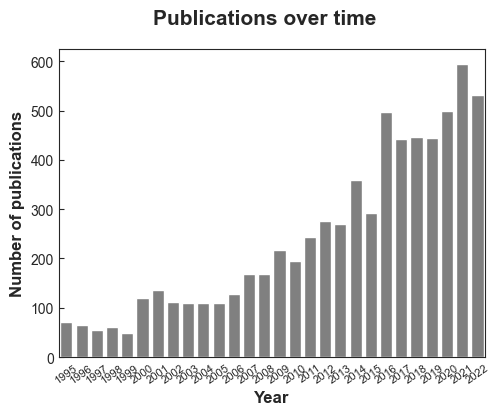

In [10]:
year=[]
for i in range(len(data)):
    try:
        year.append(int(data['date'][i]))
    except:
        pass
y=[(i,(year.count(i))) for i in year]
plt.figure(figsize=(5.5,4))
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.barplot(x=[i[0] for i in set(y)],y=[i[1] for i in set(y)], color="grey")
plt.xticks(rotation=35, fontsize=8)
plt.yticks(fontsize=10)
plt.suptitle('Publications over time', fontsize=15,fontweight='bold') 
plt.ylabel('Number of publications', fontsize=12,fontweight='bold')
plt.xlabel('Year', fontsize=12,fontweight='bold')
plt.show()

In [7]:
source=data.source.unique()
datas=[data[data.source==source[i]].groupby('date').count().doi.reset_index() for i in range(5)]
color=['#e7b45d', '#be929f', '#a49faa', '#94b4c4', '#39628d']

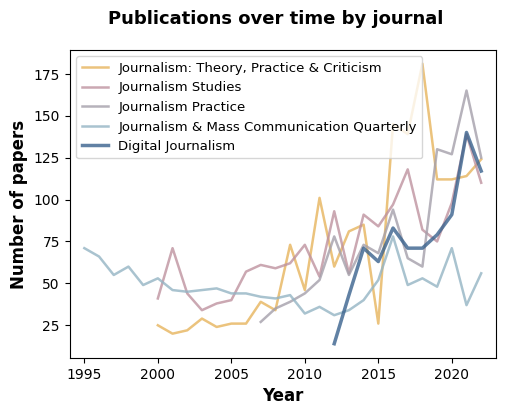

In [8]:
fig, ax=plt.subplots(1,1, figsize=(5.5,4))
a=0
for i in datas:
    if source[a]!='Digital Journalism':
        ax.plot(i['date'], i.doi, linewidth=1.8, label=source[a], color=color[a], alpha=0.8)
    else:
        ax.plot(i['date'], i.doi, linewidth=2.5, label=source[a], color=color[a], alpha=0.8)
    a+=1
ax.set_ylabel('Number of papers', fontsize=12,fontweight='bold')
ax.set_xlabel('Year', fontsize=12,fontweight='bold')
ax.set_xlim(1994, 2023)
plt.suptitle('Publications over time by journal', fontsize=13,fontweight='bold') 
ax.legend(fontsize=9.5)
plt.show()

In [9]:
data['reference_count']=data.referenced_works.apply(lambda x:len(list(set(eval(x)))))

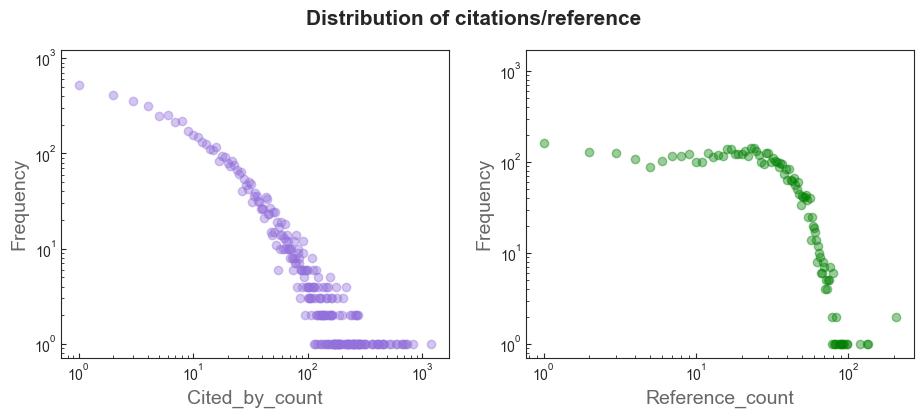

In [14]:
count=np.sort(data.cited_by_count.values)
ws = Counter(count)
count=list(set(count))
fre=[ws[i] for i in count]
count_1=np.sort(data.reference_count.values)
ws_1 = Counter(count_1)
count_1=list(set(count_1))
fre_1=[ws_1[i] for i in count_1]

fig, ax= plt.subplots(1,2, figsize=(11,4))
plt.suptitle('Distribution of citations/reference', fontsize=15,fontweight='bold') 
ax[0].plot(count, fre, 'o', color='mediumpurple',alpha = 0.4)
ax[0].set( xscale='log',yscale='log')
ax[0].set_xlabel('Cited_by_count', size = 14,alpha=0.7)
ax[0].set_ylabel('Frequency', size = 14,alpha=0.7)

ax[1].plot(count_1, fre_1, 'o', color='green',alpha = 0.4)
ax[1].set( xscale='log',yscale='log')
ax[1].set_xlabel('Reference_count', size = 14,alpha=0.7)
ax[1].set_ylabel('Frequency', size = 14,alpha=0.7)

plt.show()


### Data validity checks
<div style="background:#e7edf7; border-left:solid 2px yellow; padding-left:10px;">
    ⚠️  Note that many papers have <b>0</b> citations or reference

</div>

10 papers were randomly sampled in each case. 
1. For the uncited papers, **8 out of 10** were truly uncited. 
2. As for the unreferenced papers, the information was missing on the webpage. 

For papers with only one reference, the majority of the missing sources were non-research papers such as reports, presentations, news articles, books, and foreign language books.





In [ ]:
data_no_citation=data[data.cited_by_count==0].sample(10)
data_no_reference=data[data.reference_count==0].sample(10)

In [49]:
data_no_citation.doi

5811         https://doi.org/10.1177/1077699019827962
5820       https://doi.org/10.25384/sage.c.5066754.v1
6719    https://doi.org/10.1080/21670811.2021.1882868
5801         https://doi.org/10.1177/1077699016630320
3194    https://doi.org/10.1080/1461670x.2022.2029541
5876       https://doi.org/10.1177/107769900107800213
4469    https://doi.org/10.1080/17512786.2021.2024083
6682     https://doi.org/10.1080/21670811.2014.946310
5894       https://doi.org/10.1177/107769900408101s02
3296    https://doi.org/10.1080/1461670x.2022.2139745
Name: doi, dtype: object

In [50]:
data_no_reference.doi

4626       https://doi.org/10.1177/107769909907600102
5070       https://doi.org/10.1177/107769909707400105
5215         https://doi.org/10.1177/1077699013493792
5405       https://doi.org/10.1177/107769900908600208
3131     https://doi.org/10.1080/1461670x.2012.662411
6685    https://doi.org/10.1080/21670811.2016.1168614
5327         https://doi.org/10.1177/1077699015574098
2066          https://doi.org/10.1080/146167000441385
5523       https://doi.org/10.1177/107769900308000211
5136       https://doi.org/10.1177/107769909707400103
Name: doi, dtype: object

In [52]:
data_1_reference=data[data.reference_count==1].sample(10)
data_1_reference.doi.to_list()

['https://doi.org/10.1080/17512780802280984',
 'https://doi.org/10.1080/1461670x.2012.662413',
 'https://doi.org/10.1080/14616700902987207',
 'https://doi.org/10.1080/17512786.2014.943930',
 'https://doi.org/10.1177/1464884909102591',
 'https://doi.org/10.1177/1464884908098322',
 'https://doi.org/10.1080/14616700701504666',
 'https://doi.org/10.1177/1077699016646790',
 'https://doi.org/10.1177/1464884914529210',
 'https://doi.org/10.1080/17512786.2012.740242']

<hr>

## 🔢Document co-citation analysis

> The undirected **co-citation network analysis** is employed as the de facto standard to unveil the intellectual structure in bibliometrics. 

👉 So, lets build the network and cluster it
* To build a CC network, we need to match the received citation


In [ ]:
# outgoing citations
out_edges=[]
for i in tqdm(range(len(data))):
    try:
      ref_l=eval(data.referenced_works[i])
      oa_year=data.loc[i, 'date']
      for r in range(len(ref_l)):
          out_edges.append((data.id[i].replace("https://openalex.org/", ""),ref_l[r].replace("https://openalex.org/", ""), oa_year))
    except:
        pass

In [11]:
os.chdir('../data/citation/')
data_list=[i.replace("https://openalex.org/", "") for i in data.id]

In [ ]:
# incoming citations
paths= [i for i in glob.glob('*.pkl') if i.split('.')[0] in data_list]
in_edges=[]
for n in tqdm(paths):
    df=pd.read_pickle(n)
    try:
        for i in range(len(df)):
            oa_id=df.loc[i, 'id'].replace("https://openalex.org/", "")
            oa_year=df.loc[i, 'publication_year']
            in_edges.append((oa_id, n.split('.')[0], oa_year))
    except: 
        pass

In [18]:
bc=pd.DataFrame(out_edges,columns=['citing', 'cited', "year"]).drop_duplicates().reset_index(drop=True)
cc=pd.DataFrame(in_edges,columns=['citing', 'cited', "year"]).drop_duplicates().reset_index(drop=True)
cc_in=bc[bc.cited.isin(data_list)]
citations=pd.concat([cc, bc]).drop_duplicates(subset=["citing", "cited"]).reset_index(drop=True)

In [21]:
md('Total number of citation links related to the corpus: {}'.format(len(citations)))

Total number of citation links related to the corpus: 260018

In [22]:
md('Total number of outgoing citation links: {}; Total number of incoming citation links: {}, including external citations: {} and internal citations: {}'.format(len(bc),len(cc), len(cc)-len(cc_in), len(cc_in)))

Total number of outgoing citation links: 141975; Total number of incoming citation links: 152229, including external citations: 118043 and internal citations: 34186

In [12]:
# set papers to indexes 
np_article=np.array(data_list).reshape(-1,1)
index_doi=dict(enumerate(np_article[:,0])) 
doi_index=dict((j,i) for i,j in enumerate(np_article[:,0]))

In [24]:
cc["cited_index"]=cc.cited.apply(lambda i: doi_index[i])

In [ ]:
#cocitation links
co_ci=[]
for i in tqdm(cc.groupby('citing').groups):
  #return the index of the groupby object
  j=cc[cc['citing']==i].cited_index.to_list()
  year=cc[cc['citing']==i].year.to_list()[0]
  if len(j)>1:
    co_ci=co_ci+([(n,str(year)) for n in combinations(j,2)])

In [73]:
def links_to_df(links):
    df=pd.DataFrame(links,columns=['links', 'year'])
    df['p1']=df.links.apply(lambda x: x[0])
    df['p2']=df.links.apply(lambda x: x[1])
    return df[['p1', 'p2', 'year']]

cc=links_to_df(co_ci)
#cc.to_pickle('../data/cc_with_year.pickle')

In [131]:
cc=pd.read_pickle('../data/cc_with_year.pickle')

In [29]:
md('Total number of co-citation links: {}'.format(len(cc)))

Total number of co-citation links: 513194

### Network analysis

In [13]:
def df_to_list(df, p1, p2):
  return [tuple(sorted(i)) for i in df[[p1, p2]].values.tolist()]

# build a network 
def build_network(ls):
    count=dict(Counter(ls))
    edges=[(i+(count[i],)) for i in count]
    G=nx.Graph()
    G.add_weighted_edges_from(edges)
    return G

# some network quantities
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)           
def f_gcc(G):                   # fraction of nodes in GCC
    GCC = max(connected_component_subgraphs(G),key=len)
    return GCC.number_of_nodes()/G.number_of_nodes()
def a_d(G):
    return sum([d for (n, d) in nx.degree(G)]) / float(G.number_of_nodes())

def acc(G):
    nodes = [n for n in G.nodes() if G.degree(n) >1]
    clustering = nx.clustering(G, nodes)
    return sum(clustering.values())/len(clustering)
  
def commu_detect(G):
  im = infomap.Infomap()
  links=[(i,j) for i,j in list(G.edges())]
  im.add_links(links)
  im.run()
  communities = im.get_modules()
  n= im.num_top_modules
  m=modularity(G, communities)
  nx.set_node_attributes(G,communities,'community')
  return n, np.round(m, 3), communities
  
def modularity(G, communities):
  v = defaultdict(list)
  for key, value in sorted(dict(communities).items()):
      v[value].append(key)
  return np.round(nx_comm.modularity(G, v.values()), 3)

# some network quantities
def f_n(i,ls):
  return ls[i].number_of_nodes()/ls[-1].number_of_nodes() #%Nt
def f_e(i,ls):
  return ls[i].number_of_edges()/ls[-1].number_of_edges() #%Et
def f_w(i,ls):
  return sum([e[2]['weight'] for e in ls[i].edges(data=True)])/sum([e[2]['weight'] for e in ls[-1].edges(data=True)])#%Wt
  

In [31]:
# weighted co-citation network 
co_ci=df_to_list(cc, 'p1', 'p2')
G=build_network(co_ci)

In [32]:
GCC=max(connected_component_subgraphs(G),key=len)
print("The co-citation network:")
print(G.number_of_nodes(), "nodes", G.number_of_edges(),"links") 
print("Average clustering coefficient", acc(G))
print("Average degree", a_d(G))
print("Giant connected component ", GCC.number_of_nodes(), "nodes", "faction", np.round(GCC.number_of_nodes()/G.number_of_nodes(), 3))

The co-citation network:
5723 nodes 305193 links
Average clustering coefficient 0.44611421787663147
Average degree 106.65490127555478
Giant connected component  5717 nodes faction 0.999


After building the networks, 
* we filter the links to reduce the number of links that are otherwise too dense for community analysis
* we then apply several community detection algorithms: **`Infomap`** and **`Leiden`**

In [20]:
## Filtered network 
G_co2=nx.read_gexf("../data/g_co_f2.gexf")

In [35]:
g_ls=[G_co2,G]
print("Co-citation network after filtering (α=0.2)")
print("number of nodes after filtering: ", g_ls[0].number_of_nodes(), np.round(f_n(0, g_ls), 3))
print("number of edges after filtering: ", g_ls[0].number_of_edges(), np.round(f_e(0, g_ls), 3))
print("percentage of weights after filtering: ",  np.round(f_w(0, g_ls), 3))
print("Average clustering coefficient", np.round(acc(g_ls[0]), 3))
print("Average degree", np.round(a_d(g_ls[0]), 3))
GCC_1=max(connected_component_subgraphs(g_ls[0]),key=len)
print("Giant connected component:", GCC_1.number_of_nodes(), "nodes", "faction", np.round(GCC_1.number_of_nodes()/g_ls[0].number_of_nodes(),3))

Co-citation network after filtering (α=0.2)
number of nodes after filtering:  4349 0.76
number of edges after filtering:  40778 0.134
percentage of weights after filtering:  0.416
Average clustering coefficient 0.461
Average degree 18.753
Giant connected component: 4280 nodes faction 0.984


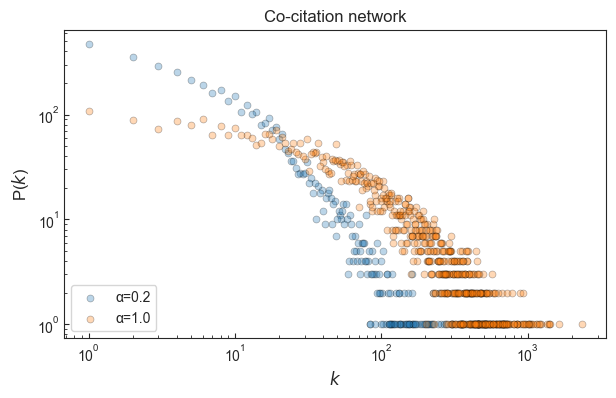

In [37]:
fig, col = plt.subplots(1,1,figsize=(7,4))
label=['α=0.2','α=1.0']
ls_w=[]
ls_c=[]
for i,j in enumerate(g_ls):
  w, c =  zip(*Counter([d for n, d in j.degree()]).items())
  ls_w.append(w)
  ls_c.append(c)
markers=['o','s','X','v']
titles="Co-citation network"
for i in range(2): 
  col.scatter(ls_w[i],ls_c[i], label=str(label[i]),edgecolors='black',s=25,linewidths=0.5, alpha=0.3)
  col.set_xlabel("$k$", fontsize=12)
  col.set_xscale("log")
  col.set_yscale("log")
  col.set_title(titles)
  col.set_ylabel("P($k$) ", fontsize=12)
  col.legend(loc='lower left')
plt.show()

In [18]:
def g_t(G):
    G1 = nx.Graph()
    links=[(eval(i),eval(j)) for i,j in list(G.edges())]
    G1.add_edges_from(links)
    return G1

In [16]:
g = igraph.Graph.TupleList(G_co2.edges(), directed=False)
part = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition);
g.vs['cluster'] = part.membership
nx.set_node_attributes(G_co2, dict(zip(g.vs['name'], g.vs['cluster'])),'community_leiden')
a=(len(list(set(part.membership))), modularity(G_co2, dict(zip(g.vs['name'], g.vs['cluster']))) )

In [32]:
print('Infomap')
com1=commu_detect(g_t(G_co2))
nx.set_node_attributes(G_co2, dict(zip( G_co2.nodes(),[com1[-1][eval(i)] for i in G_co2.nodes()])),'community')
print('n_clusters and modularity', com1[:2])

print('Leiden')
print('n_clusters and modularity', a)

Infomap
n_clusters and modularity (169, 0.472)
Leiden
n_clusters and modularity (47, 0.572)


#### CC network
<p float="left">
  <img src="cc.png" width="550" />
  <img src="color_bar.png" width="80" /> 
</p>


**RQ1**: What are the most prevalent journalism research clusters, and how are they related to each other ❓

In [77]:
# node information 
cate=pd.DataFrame()
data["id1"]=[i.replace("https://openalex.org/", "") for i in data.id]
cate['id1']=[index_doi[eval(str(i))] for i in G_co2.nodes()]
cate['Node_id']=[i for i in G_co2.nodes()]
cate['Community']=[G_co2.nodes[i]['community_leiden'] for i,j in G_co2.nodes(data=True)]
cate['Degree']=[G_co2.degree(i) for i in G_co2.nodes()]
cate_node=cate.merge(data,on=['id1'])
cate_node["Community"]=cate_node["Community"] +1

In [33]:
cate=pd.DataFrame()
cate['node1']=[index_doi[eval(i)] for i,j in G_co2.edges()]
cate['node2']=[index_doi[eval(j)] for i,j in G_co2.edges()]
cate['node_id1']=[i for i,j in G_co2.edges()]
cate['node_id2']=[j for i,j in G_co2.edges()]
cate['Community1']=[G_co2.nodes[i]['community_leiden']+1 for i,j in G_co2.edges()]
cate['Community2']=[G_co2.nodes[j]['community_leiden']+1 for i,j in G_co2.edges()]
cate1=cate[cate.Community1!=cate.Community2].reset_index(drop=True)
cate1=cate1[cate1.Community2.isin(range(11))]
cate1=cate1[cate1.Community1.isin(range(11))]
edges1=df_to_list(cate1, 'Community1', "Community2")

In [73]:
def scale_lightness(rgb, scale_l):
    h, l, s = colorsys.rgb_to_hls(*rgb)
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)
def plot(G,size,alpha, sizes_dict):
  plt.figure(figsize=(5.5,4))
  pos=nx.spring_layout(G)
  values =[node for node,j in G.nodes(data=True)]
  sizes = [sizes_dict[node]*2 for node,j in G.nodes(data=True)]
  labels, colors = {}, {}
  color_map = np.array(sns.color_palette("Paired", 10))
  for node in sorted(G.nodes()):
    labels[node] = str(int(node))
    colors[node]=color_map[node-1]
  edgewidth = [ d['weight']/200 for (u,v,d) in G.edges(data=True)]
  nx.draw_networkx_nodes(G,pos=pos,node_color=[colors[i] for i in G.nodes()],node_size=sizes, linewidths=1.5, alpha=0.9, edgecolors=[scale_lightness(colors[i], 0.8) for i in G.nodes()])
  nx.draw_networkx_labels(G,pos=pos,font_size=10,font_color='black',labels=labels)
  nx.draw_networkx_edges(G,pos=pos, width=edgewidth, alpha=alpha)
  plt.axis('off')
  plt.show()

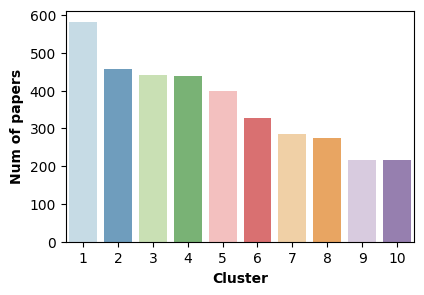

In [46]:
sizes=cate_node.groupby("Community").count().reset_index().iloc[:10]
sizes_dict=dict(zip(sizes.Community, sizes.id1))
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(4.5,3) ) 
sns.barplot(x=list(range(1, 11)), y=list(sizes_dict.values()), palette="Paired", alpha=0.7)
ax.set_ylabel("Num of papers", fontsize=10, fontweight='bold')
ax.set_xlabel("Cluster", fontsize=10, fontweight='bold');


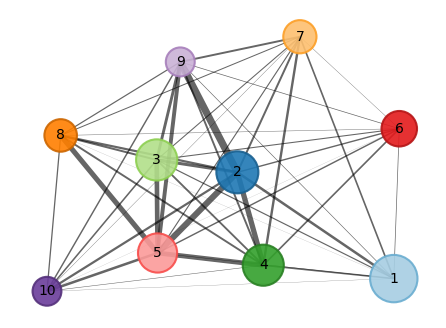

In [75]:
G_mega1=build_network(edges1)
plot(G_mega1,500,0.6, sizes_dict)

#### Wordcloud for the clusters using abstracts+ titles 


<div style="background:#e7edf7; border-left:solid 2px yellow; padding-left:10px;">
    ⚠️ <b> 6333 (94%) </b>  abstracts are available, whereas some abstracts <b> (437 of 6770, 6%) </b> are not available <br></div>

In [6]:
# a function to restore the original text 
from functools import reduce 
def original_text(dic):
    ls=[]
    for i in range(reduce(lambda count, l: count + len(l), dic.values(), 0)):
        for j in dic.keys():
            if i in dic[j]:
                ls.append(j)
    return " ".join(ls)


In [ ]:
data['text']=data.title.apply(lambda x: x.lower())
for i,t in tqdm(enumerate(data.abstract_inverted_index)):
    try:
        if data.original_abstract[i].lower().split(" ")[0]=="abstract":
            data.at[i, "text"]= " ".join(data.original_abstract[i].lower().split(" ")[1:])+ " "+data.title[i].lower()
        else:    
            data.at[i, "text"]= data.original_abstract[i].lower()+ " "+data.title[i].lower()
    except:
        pass

In [87]:
data[~data.original_abstract.isna()].shape

(6333, 47)

##### Text Preprocessing 

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
import spacy
from spacy.tokenizer import Tokenizer
from tqdm import tqdm
import itertools
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

In [9]:
# filter out punctuation, space and stopwords 
# customize tokenizer for hypen connector
def custom_tokenizer(nlp):
    infix_re = re.compile(r'~')
    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)
    return Tokenizer(nlp.vocab,infix_finditer=infix_re.finditer,prefix_search=prefix_re.search,
                                suffix_search=suffix_re.search)
def token_filter(token):
    return not (token.is_punct | token.is_space | token.is_stop | token.is_digit)
def preprocess_doc(texts):
    # rule-based lemmatizer exceptions for central words such as media, data, learning, embedding
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    nlp.tokenizer = custom_tokenizer(nlp)
    nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["data"] = ["data"]
    nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["media"] = ["media"]
    nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["verb"]["learning"] = ["learning"]
    nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["verb"]["embedding"] = ["embedding"]
    assert nlp("data")[0].lemma_ == "data"
    assert nlp("media")[0].lemma_ == "media"
    filtered_tokens = []
    for doc in tqdm(nlp.pipe(texts,batch_size=50)):
        tokens = [token.text for token in doc if token_filter(token)]
        tokens = [token.lemma_ for token in doc if token_filter(token)]
        filtered_tokens.append(tokens)
    return filtered_tokens

In [ ]:
data['doc']=preprocess_doc(data.text.to_list())

Word Collocation 

In [11]:
#phrase_model
docs=data.doc.to_list()
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.test.utils import datapath
import gensim
from gensim.models.word2vec import Word2Vec
sentence=[i for i in docs]
phrases_model = Phrases(sentence, min_count=20, threshold=10,  delimiter='-',scoring='default',connector_words=ENGLISH_CONNECTOR_WORDS)
for phrase, score in phrases_model.find_phrases(sentence).items():
    print(phrase, score)

professional-identity 33.69013773409274
20th-century 600.0715818516247
united-states 498.2504853281565
mainstream-media 10.31576517472804
journalistic-norm 15.38824101909386
content-analysis 38.583370937364485
past-year 40.09285677710072
news-production 10.587752052501889
journalistic-practice 15.274491512907677
user-generated-content 72.61922330311252
article-conclude 14.135704970773782
english-language 638.2761881470612
new-technology 16.00920761245675
article-explore 12.036187057395017
public-relation 40.249044374004384
news-organization 11.78571995299071
starting-point 474.6348077350523
study-examine 14.58785897871036
finding-suggest 37.0578229370404
rely-heavily 210.28577993697476
real-world 30.898664721918358
case-study 22.36480327565222
presidential-campaign 79.29727868420787
middle-east 1320.582560296846
media-system 12.229149242964434
news-item 11.914921945040424
journalistic-professionalism 21.53505905702391
article-argue 13.357154715203052
discursive-construction 28.31005297

In [12]:
data['coll'] = data.doc.apply(lambda x:phrases_model[x]).values

Some corpus-specific stop words 

In [13]:
data['text1']=data.coll.apply(lambda x: ' '.join(x))

In [14]:
corpus=[j for i in data.coll for j in i]
allWordDist = nltk.FreqDist(w.lower() for w in corpus) 
allWordDist.most_common(15)

[('news', 11367),
 ('journalism', 7798),
 ('media', 6839),
 ('journalist', 6687),
 ('study', 5039),
 ('newspaper', 2797),
 ('article', 2591),
 ('coverage', 2341),
 ('political', 2209),
 ('research', 2196),
 ('practice', 2193),
 ('role', 2160),
 ('use', 2050),
 ('analysis', 1921),
 ('journalistic', 1885)]

In [118]:
j_stop=['news', 'journalism', 'journalist', 'study', 'use' ,'article' ,'journalistic', 'analysis',"research", "media", "use"]

In [15]:
term=[]
for i in range(len(data)):
    term+=data.coll[i]
md('Total number of terms: {}, number of unique terms: {}'.format( len(term), len(Counter(term)) ))

Total number of terms: 522362, number of unique terms: 26134

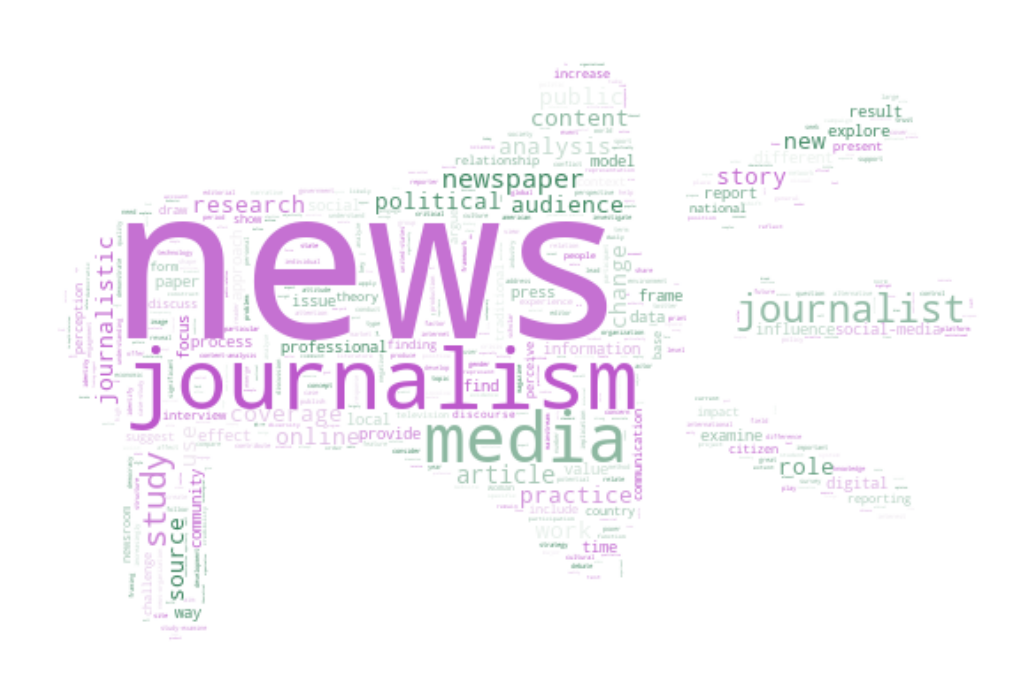

In [107]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
count=Counter([i.replace(' ','-') for i in term if i])
mask = np.array(Image.open('../data/mask.png'))
wordcloud = WordCloud(width=800, height=400,max_font_size=300,min_font_size=2,mask=mask, max_words=2000, collocations=True, contour_width=0, colormap=sns.diverging_palette(145, 300, as_cmap=True), contour_color='grey', background_color="white").generate_from_frequencies(dict(count))
# Display the generated wordcloud
plt.figure( figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear' )
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**RQ2**: How are topics related to the digital aspects reflected in journalism research 
clusters ❓

##### TF-IDF
1. First, we calculate the **TF** for each word which is the count of each word in a given cluster.
2. Then we calculate the **IDF**, inverse document frequency, which is a measure of how much information a word provides, i.e. if it's common or rare across all clusters [[1]](https://en.wikipedia.org/wiki/Tf–idf#Inverse_document_frequency_2). 

We have

$${\text{idf}(t,D) = \log{\frac{N}{ 1+|\{d\in D : t\in d\}|}}}$$


In [112]:
cate=pd.DataFrame()
data["id1"]=[i.replace("https://openalex.org/", "") for i in data.id]
cate['id1']=[index_doi[eval(str(i))] for i in G_co2.nodes()]
cate['Node_id']=[i for i in G_co2.nodes()]
cate['Community']=[G_co2.nodes[i]['community_leiden'] for i,j in G_co2.nodes(data=True)]
cate['Degree']=[G_co2.degree(i) for i in G_co2.nodes()]
cate_node=cate.merge(data,on=['id1'])
cate_node["Community"]=cate_node["Community"] +1
cate_node['docs']=cate_node.coll.apply(lambda x: ' '.join(x))
cc1=cate_node.groupby('Community')['docs'].apply(' '.join).reset_index()
docs=cc1.docs.to_list()

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import nltk

cv = CountVectorizer(tokenizer=word_tokenize, analyzer='word')
word_count_vector = cv.fit_transform(docs)
tf = pd.DataFrame(word_count_vector.toarray(), columns=cv.get_feature_names_out())
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(word_count_vector)
idf = pd.DataFrame({'feature_name':cv.get_feature_names_out(), 'idf_weights':tfidf_transformer.idf_})
tf_idf = pd.DataFrame(X.toarray() ,columns=cv.get_feature_names_out())

In [116]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from PIL import Image
def display_wordcloud(top_words, title, n_components, a, cmaps):
    plt.figure(figsize=(20, 4))
    j = np.ceil(n_components/2)
    b=0
    for t in range(n_components):
        i=t+1
        plt.subplot(int(j), 2, i).set_title("Cluster #" + str(t+a+1), fontsize=20,fontweight='bold')
        plt.plot()
        plt.imshow(WordCloud(width=800, height=400,max_font_size=120,min_font_size=5, max_words=200,background_color="white", color_func=lambda *args, **kwargs: cmaps[b]).generate_from_frequencies(top_words[t+a]))
        plt.axis("off")
        b+=1
    plt.show()


In [119]:
words={}
for i in range(2):
    tf=[i for i in tf_idf.sort_values(by=i, ascending=False, axis=1).columns[:200] if i not in j_stop]
    words[i]=tf_idf[list(tf)].iloc[i].to_dict()

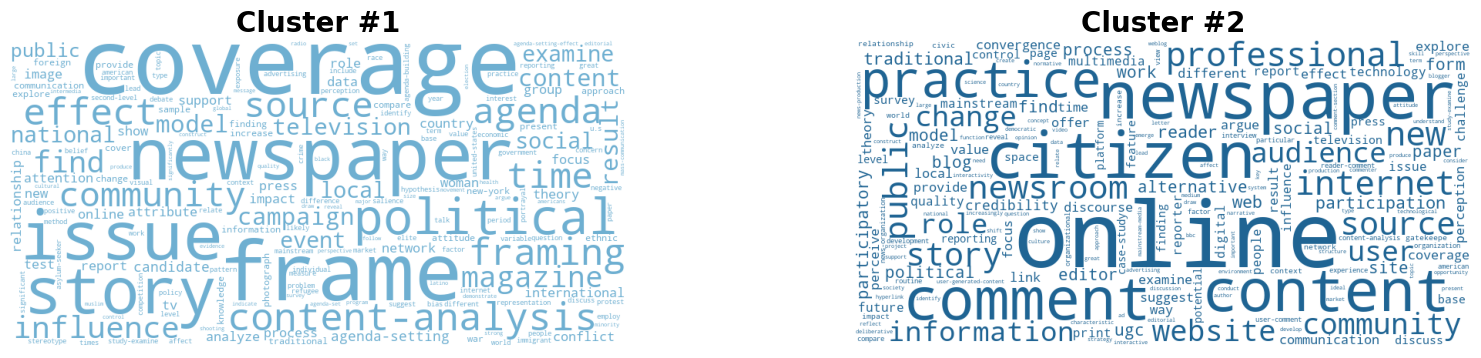

In [103]:
display_wordcloud(words, "Wordcloud", 2, 0, ['rgba(110,175,209,255)', '#1f6493'])

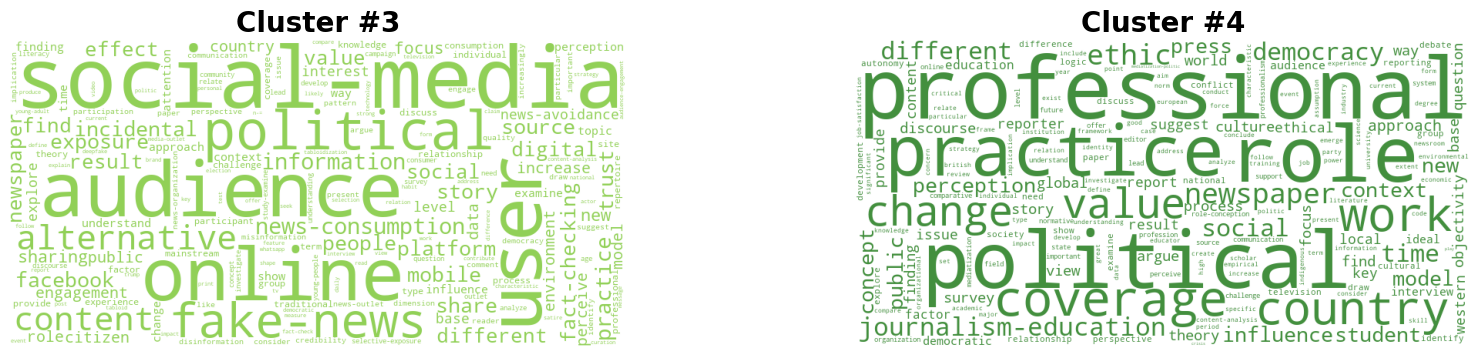

In [85]:
display_wordcloud(words, "Wordcloud", 2, 2, ['#91d057', '#438f3e'])

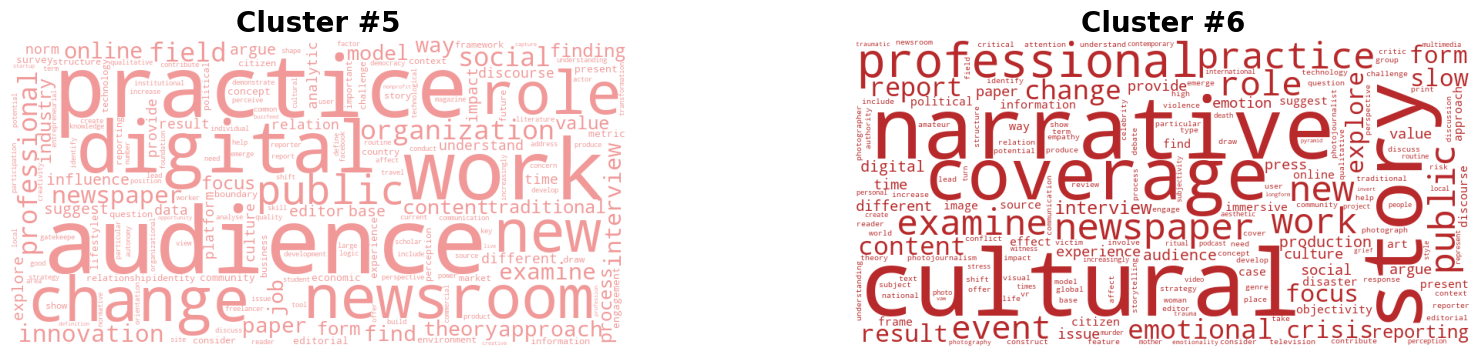

In [867]:
display_wordcloud(words, "Wordcloud", 2, 4, ['#f09998', '#b7292a'])

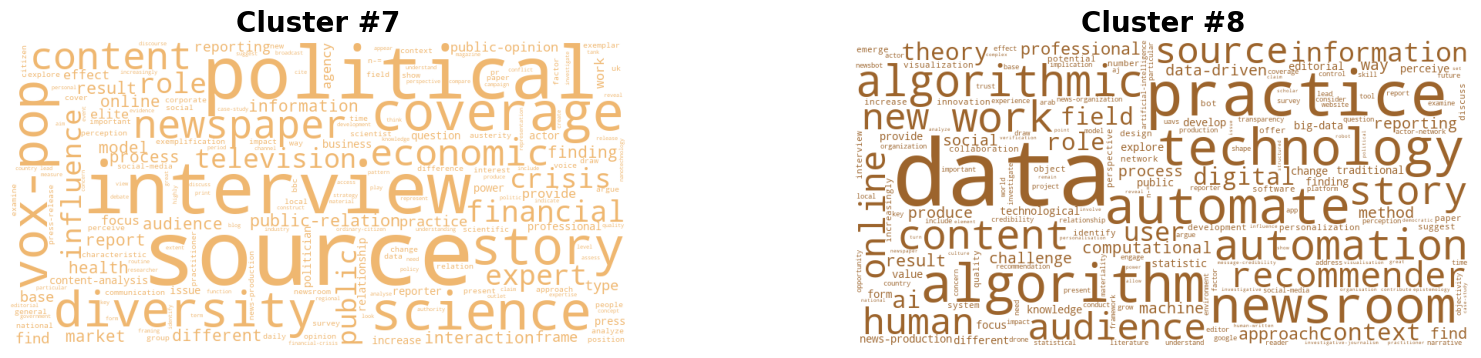

In [80]:
display_wordcloud(words, "Wordcloud", 2, 6, ['rgba(239,183,112,255)', '#9c642c'])

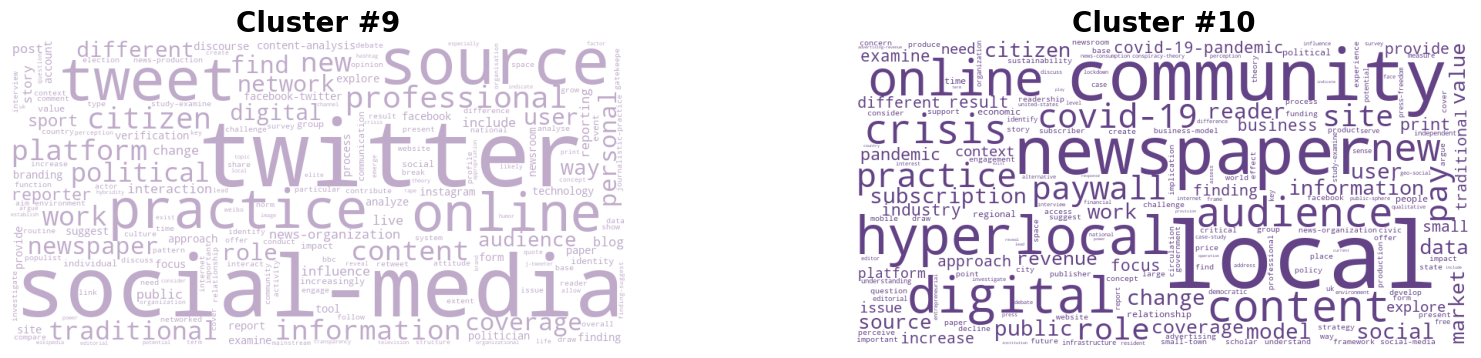

In [91]:
display_wordcloud(words, "Wordcloud", 2, 8, ['#bfaaca', '#634286'])

##### Top ten articles in each cluster based on each paper's normalized citation impact (NCI) 



In [128]:
cate_node["year_citation"]=cate_node.date.apply(lambda x: year_dict[x])
year_dict=cate_node.groupby("date").cited_by_count.mean().to_dict()
cate_node["n_citation"]=cate_node.cited_by_count/cate_node.year_citation
for i in range(1, 11):
    print("Cluster", str(i))
    a=cate_node[cate_node.Community==i].sort_values(by=["n_citation"], ascending=False).display_name.to_list()[:10]
    b=cate_node[cate_node.Community==i].sort_values(by=["n_citation"], ascending=False).date.to_list()[:10]
    c= cate_node[cate_node.Community==i].sort_values(by=["n_citation"], ascending=False).authorships.to_list()[:10]
    for i,n in enumerate(a): 
        author= "(" + eval(c[i])[0]["author"]["display_name"].split(" ")[-1]
        author= " (" + ", ".join([i["author"]["display_name"].split(" ")[-1] for i in eval(c[i])])
        year= ", " +str(b[i]) +")"
        print(a[i]+author+ year +";")
    print('\n')


Cluster 1
A Look at Agenda-setting: past, present and future (McCombs, 2005);
What's in a Frame? A Content Analysis of Media Framing Studies in the World's Leading Communication Journals, 1990-2005 (Matthes, 2009);
Quantitative analysis of large amounts of journalistic texts using topic modelling (Jacobi, Atteveldt, Welbers, 2015);
Candidate Images in Spanish Elections: Second-Level Agenda-Setting Effects (McCombs, Llamas, López-Escobar, Rey, 1997);
Issues and Best Practices in Content Analysis (Lacy, Watson, Riffe, Lovejoy, 2015);
A Longitudinal Study of Agenda Setting for the Issue of Environmental Pollution (Ader, 1995);
Agenda Setting and International News: Media Influence on Public Perceptions of Foreign Nations (Wanta, Golan, Lee, 2004);
Think about it This Way: Attribute Agenda-Setting Function of the Press and the public's Evaluation of a Local Issue (Kim, Scheufele, Shanahan, 2002);
INTER-MEDIA AGENDA SETTING AND GLOBAL NEWS COVERAGE (Golan, 2006);
The Effects of Message Fram

**RQ3**: How are the field development and structure related to the journals ❓

In [78]:
cate_=cate_node[cate_node.Community.isin([i for i in range(11)]) ]
x, y= "Community", "source"
bg=cate_.source.unique()
colors = np.array(sns.color_palette("Set2", 8))
y_l=['DJ',
 'J&MCQ',
 'JP',
 'JS',
 'J']

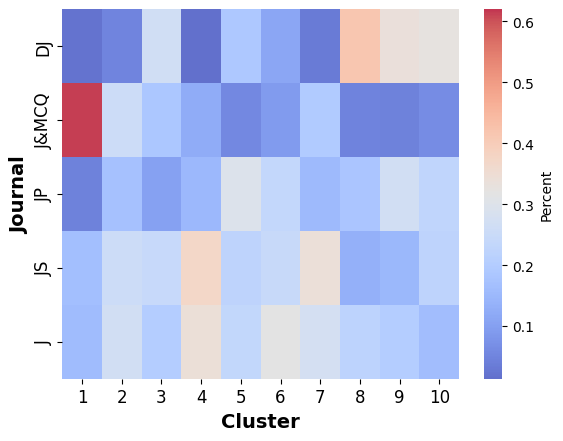

In [94]:
confusion_matrix=pd.crosstab( cate_.source, cate_.Community, normalize='columns').to_numpy()
ylabels = list(pd.crosstab( cate_.source, cate_.Community, normalize='columns').index)
ax=sns.heatmap(confusion_matrix,cmap='coolwarm', yticklabels=y_l, vmax=0.62, xticklabels=list(range(1, 11)),cbar_kws={'label': 'Percent'}, alpha=0.8)
ax.set_yticklabels(ax.get_yticklabels(), size=12)
ax.set_xticklabels(ax.get_xticklabels(), size=12)
plt.xlabel('Cluster',fontsize=14, fontweight='bold');
plt.ylabel('Journal',fontsize=14, fontweight='bold');

<hr>

## Network evolution

Across 5 periods: **1995-2004, 2005-2009, 2010-2014, 2015-2019, 2020-2022** 


In [129]:
import plotly.graph_objects as go
import matplotlib as mpt
import igraph
import leidenalg

In [132]:
cc.year=cc.year.apply(lambda x: eval(x))
cc1=cc[cc.year<2005]
cc2=cc[cc.year<2010]
cc3=cc[cc.year<2015]
cc4=cc[cc.year<2019]

In [102]:
co_ci1=df_to_list(cc1, 'p1', 'p2')
co_ci2=df_to_list(cc2,'p1', 'p2')
co_ci3=df_to_list(cc3, 'p1', 'p2')
co_ci4=df_to_list(cc4, 'p1', 'p2')

In [103]:
Gc1=build_network(co_ci1)
Gc2=build_network(co_ci2)
Gc3=build_network(co_ci3)
Gc4=build_network(co_ci4)


**RQ4**: How has the field structure evolved over time ❓

In [104]:
GCC=max(connected_component_subgraphs(Gc1),key=len)
print("Period 1:")
print(Gc1.number_of_nodes(), "nodes", Gc1.number_of_edges(),"links") 
print("Average clustering coefficient", acc(Gc1))
print("Average degree", a_d(Gc1))
print("Network density", np.round(nx.density(Gc1), 3))
print("Giant connected component ", GCC.number_of_nodes(), "nodes", "faction", np.round(GCC.number_of_nodes()/Gc1.number_of_nodes(), 3))

Period 1:
431 nodes 2009 links
Average clustering coefficient 0.6143922574647204
Average degree 9.322505800464038
Network density 0.022
Giant connected component  391 nodes faction 0.907


In [105]:
GCC=max(connected_component_subgraphs(Gc2),key=len)
print("Period 2:")
print(Gc2.number_of_nodes(), "nodes", Gc2.number_of_edges(),"links") 
print("Average clustering coefficient", acc(Gc2))
print("Average degree", a_d(Gc2))
print("Network density", np.round(nx.density(Gc2), 3))
print("Giant connected component ", GCC.number_of_nodes(), "nodes", "faction", np.round(GCC.number_of_nodes()/Gc2.number_of_nodes(), 3))

Period 2:
1045 nodes 13113 links
Average clustering coefficient 0.5505707800249496
Average degree 25.096650717703348
Network density 0.024
Giant connected component  1032 nodes faction 0.988


In [106]:
GCC=max(connected_component_subgraphs(Gc3),key=len)
print("Period 3:")
print(Gc3.number_of_nodes(), "nodes", Gc3.number_of_edges(),"links") 
print("Average clustering coefficient", acc(Gc3))
print("Average degree", a_d(Gc3))
print("Network density", np.round(nx.density(Gc3), 3))
print("Giant connected component ", GCC.number_of_nodes(), "nodes", "faction", np.round(GCC.number_of_nodes()/Gc3.number_of_nodes(), 3))

Period 3:
2127 nodes 44838 links
Average clustering coefficient 0.508974181882512
Average degree 42.160789844851905
Network density 0.02
Giant connected component  2123 nodes faction 0.998


In [107]:
GCC=max(connected_component_subgraphs(Gc4),key=len)
print("Period 4:")
print(Gc4.number_of_nodes(), "nodes", Gc4.number_of_edges(),"links") 
print("Average clustering coefficient", acc(Gc4))
print("Average degree", a_d(Gc4))
print("Network density", np.round(nx.density(Gc4), 3))
print("Giant connected component ", GCC.number_of_nodes(), "nodes", "faction", np.round(GCC.number_of_nodes()/Gc4.number_of_nodes(), 3))

Period 4:
3431 nodes 112469 links
Average clustering coefficient 0.49817845339652855
Average degree 65.56047799475371
Network density 0.019
Giant connected component  3415 nodes faction 0.995


In [108]:
class Disparity(object):
  
  # The implementation is based on the article:
  # "Extracting the multiscale backbone of complex weighted networks" M. Ángeles Serrano, Marián Boguña, Alessandro Vespignani https://arxiv.org/pdf/0904.2389.pdf
  # the sum of weights incident to the node

  def __init__(self, G):
    self.G=G
  # filter implementation
  def filter(self, a): 
      # probability density function
    def pdf(pij,k):
      return -(1-pij)**(k-1)-(-(1-0)**(k-1)) 
    #weights sum
    def s(G,i):
      neighbors = G.edges(i,data=True)
      return sum([node[2]['weight'] for node in neighbors]) 
  # normalize the weights
    def pij(G,i):
      ij=dict()
      k = len(G[i])
      if k > 1:
        for v in G[i]:
          w = G[i][v]['weight']
          p_ij = float(np.absolute(w))/s(G,i)
          ij[(i,v,w)]=p_ij
      return ij
    # filtered graph
    B=nx.Graph()
    for i in self.G.nodes():
      k=self.G.degree(i)
      if k>1:
        pi=pij(self.G,i)
        for edges in pi.keys():
          aij=pdf(pi[edges],k)
          if 1-aij <a:
            B.add_weighted_edges_from([edges])
    return B

In [109]:
G_i2, G_i3, G_i4 =Disparity(Gc2), Disparity(Gc3), Disparity(Gc4)
G_2=G_i2.filter(0.2)
G_3=G_i3.filter(0.2)
G_4=G_i4.filter(0.2)

In [110]:
g_ls2=[G_2, Gc2]
g_ls3=[G_3, Gc3]
g_ls4=[G_4, Gc4]

In [112]:
print("Period 2 after filtering (α=0.2):")
print("number of nodes after filtering: ", g_ls2[0].number_of_nodes(), np.round(f_n(0, g_ls2), 3))
print("number of edges after filtering: ", g_ls2[0].number_of_edges(), np.round(f_e(0, g_ls2), 3))
print("percentage of weights after filtering: ",  np.round(f_w(0, g_ls2), 3))
print("Average clustering coefficient", np.round(acc(g_ls2[0]), 3))
print("Average degree", np.round(a_d(g_ls2[0]), 3))
GCC_1=max(connected_component_subgraphs(g_ls2[0]),key=len)
print("Giant connected component:", GCC_1.number_of_nodes(), "nodes", "faction", np.round(GCC_1.number_of_nodes()/g_ls2[0].number_of_nodes(),3))

Period 2 after filtering (α=0.2):
number of nodes after filtering:  587 0.562
number of edges after filtering:  1527 0.116
percentage of weights after filtering:  0.329
Average clustering coefficient 0.483
Average degree 5.203
Giant connected component: 485 nodes faction 0.826


In [113]:
print("Period 3 after filtering (α=0.2):")
print("number of nodes after filtering: ", g_ls3[0].number_of_nodes(), np.round(f_n(0, g_ls3), 3))
print("number of edges after filtering: ", g_ls3[0].number_of_edges(), np.round(f_e(0, g_ls3), 3))
print("percentage of weights after filtering: ",  np.round(f_w(0, g_ls3), 3))
print("Average clustering coefficient", np.round(acc(g_ls3[0]), 3))
print("Average degree", np.round(a_d(g_ls3[0]), 3))
GCC_1=max(connected_component_subgraphs(g_ls3[0]),key=len)
print("Giant connected component:", GCC_1.number_of_nodes(), "nodes", "faction", np.round(GCC_1.number_of_nodes()/g_ls3[0].number_of_nodes(),3))

Period 3 after filtering (α=0.2):
number of nodes after filtering:  1369 0.644
number of edges after filtering:  5850 0.13
percentage of weights after filtering:  0.379
Average clustering coefficient 0.442
Average degree 8.546
Giant connected component: 1319 nodes faction 0.963


In [114]:
print("Period 4 after filtering (α=0.2):")
print("number of nodes after filtering: ", g_ls4[0].number_of_nodes(), np.round(f_n(0, g_ls4), 3))
print("number of edges after filtering: ", g_ls4[0].number_of_edges(), np.round(f_e(0, g_ls4), 3))
print("percentage of weights after filtering: ",  np.round(f_w(0, g_ls4), 3))
print("Average clustering coefficient", np.round(acc(g_ls4[0]), 3))
print("Average degree", np.round(a_d(g_ls4[0]), 3))
GCC_1=max(connected_component_subgraphs(g_ls4[0]),key=len)
print("Giant connected component:", GCC_1.number_of_nodes(), "nodes", "faction", np.round(GCC_1.number_of_nodes()/g_ls4[0].number_of_nodes(),3))

Period 4 after filtering (α=0.2):
number of nodes after filtering:  2376 0.693
number of edges after filtering:  14961 0.133
percentage of weights after filtering:  0.394
Average clustering coefficient 0.458
Average degree 12.593
Giant connected component: 2310 nodes faction 0.972


In [115]:
def leiden_detection(G):
    g = igraph.Graph.TupleList(G.edges(), directed=False)
    part = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition);
    g.vs['cluster'] = part.membership
    nx.set_node_attributes(G, dict(zip(g.vs['name'], g.vs['cluster'])),'community_leiden')
    a=(len(list(set(part.membership))), modularity(G, dict(zip(g.vs['name'], g.vs['cluster']))) )
    return G, a

In [116]:
print('Leiden cumulative')
G1,a1=leiden_detection(Gc1)
G_2,a2=leiden_detection(G_2)
G_3,a3=leiden_detection(G_3)
G_4,a4=leiden_detection(G_4)
print('CC1: n_clusters and modularity', a1)
print('CC2: n_clusters and modularity', a2)
print('CC3: n_clusters and modularity', a3)
print('CC4: n_clusters and modularity', a4)

Leiden cumulative
CC1: n_clusters and modularity (26, 0.657)
CC2: n_clusters and modularity (45, 0.727)
CC3: n_clusters and modularity (42, 0.561)
CC4: n_clusters and modularity (44, 0.543)


In [ ]:
a=1
for i in [G1, G_2, G_3, G_4]:
    nx.write_gexf(i, "g_bc_c"+str(a)+".gexf")
    a+=1
#nx.write_gexf(G_bc1, "g_bc_f.gexf")

In [134]:
G1=nx.read_gexf("../data/g_co_c1.gexf")
G2=nx.read_gexf("../data/g_co_c2.gexf")
G3=nx.read_gexf("../data/g_co_c3.gexf")
G4=nx.read_gexf("../data/g_co_c4.gexf")


In [135]:
def nodes_df(G):
    cate1=pd.DataFrame()
    cate1['id1']=[index_doi[eval(i)] for i in G.nodes()]
    cate1['Node_id']=[i for i in G.nodes()]
    cate1['Community']=[G.nodes[i]['community_leiden']+1 for i,j in G.nodes(data=True)]
    cate1['Degree']=[G.degree(i) for i in G.nodes()]
    cate1=cate1.merge(data,on=['id1'], how='left')
    return cate1


##### Top three articles in each cluster based on degree

In [144]:
data['id1']=[i.replace("https://openalex.org/", "") for i in data.id]
cate_1, cate_2, cate_3, cate_4, cate_5=nodes_df(G1), nodes_df(G2), nodes_df(G3), nodes_df(G4), nodes_df(G_co2)

In [137]:
for i in range(1,6):
    print("Cluster", str(i))
    a=cate_1[cate_1.Community==i].sort_values(by=["Degree"], ascending=False).display_name.to_list()[:3]
    for n in a: 
        print(n)
    print('\n')

Cluster 1
Cruising is Believing?: Comparing Internet and Traditional Sources on Media Credibility Measures
Interactivity, Online Journalism, and English-Language Web Newspapers in Asia
Perceptions of Internet Information Credibility


Cluster 2
News Media, Candidates and Issues, and Public Opinion in the 1996 Presidential Campaign
Old-Growth Forests on Network News: News Sources and the Framing of An Environmental Controversy
The Sound Bites, the Biters, and the Bitten: An Analysis of Network TV News Bias in Campaign ′92


Cluster 3
The objectivity norm in American journalism*
National News Cultures: A Comparison of Dutch, German, British, Australian, and U.S. Journalists
Understanding the Global Journalist: a hierarchy-of-influences approach


Cluster 4
The Interaction of News and Advocate Frames: Manipulating Audience Perceptions of a Local Public Policy Issue
The Effects of Message Framing on Response to Environmental Communications
Constructing Reality: Print Media's Framing of the

In [145]:
cate_1=cate_1.merge(cate_2[["Node_id", "Community"]], on=['Node_id'], how="outer")
cate_1=cate_1.merge(cate_3[["Node_id", "Community"]], on=['Node_id'], how="outer")
df1=cate_1[["Node_id", "Community_x", "Community_y", "Community"]]
df1.columns=["Node_id", 'Period_1_commu','Period_2_commu','Period_3_commu']
df1.Node_id=df1.Node_id.astype(int)

In [ ]:
cate_5.Node_id=cate_5.Node_id.astype(int)
cate_4.Node_id=cate_4.Node_id.astype(int)
df1=df1.merge(cate_4[["Node_id", "Community"]], on=['Node_id'], how="outer")
df1=df1.merge(cate_5[["Node_id", "Community"]], on=['Node_id'], how="outer")

In [148]:
df1.columns=["Node_id", 'Period_1_commu','Period_2_commu','Period_3_commu', 'Period_4_commu', 'Period_5_commu']
data['Node_id']=data.id1.apply(lambda x: doi_index[x])
df1=df1.merge(data[['Node_id', 'source']], on=['Node_id'])
df1_copy=df1.copy()

In [149]:
df1=df1_copy.copy()

In [194]:
data_j=[i for i in cate_5[cate_5.Community.isin([8])].Node_id.to_list()]

In [151]:
#flow change
#t1 -t2
#df1=df1[df1.Node_id.isin(data_j)].reset_index(drop=True)
df=pd.DataFrame(columns=['source','target'])
a=0
for i in df1.Period_1_commu.unique():
  t1=df1[df1.Period_1_commu==i].groupby('Period_2_commu').size().index.to_list()
  v1=df1[df1.Period_1_commu==i].groupby('Period_2_commu').size().to_list()
  for j in range(len(t1)):
    df.loc[a+j,'source']='T1C'+str(int(i)) + "_0"
    df.loc[a+j,'target']='T2C'+str(int(t1[j]))+"_1"
    df.loc[a+j,'value']=v1[j]
  a=len(df)

t0=df1[df1.Period_1_commu.isna()].groupby('Period_2_commu').size().index.to_list()
v0=df1[df1.Period_1_commu.isna()].groupby('Period_2_commu').size().to_list()
for j in range(len(t0)):
    df.loc[a+j,'source']='NewPapers_T2' +"_0"
    df.loc[a+j,'target']='T2C'+str(int(t0[j])) +"_1"
    df.loc[a+j,'value']=v0[j]
a=len(df)

# t2-t3
for i in df1.Period_2_commu.unique():
  t1=df1[df1.Period_2_commu==i].groupby('Period_3_commu').size().index.to_list()
  v1=df1[df1.Period_2_commu==i].groupby('Period_3_commu').size().to_list()
  for j in range(len(t1)):
    df.loc[a+j,'source']='T2C'+str(int(i)) +"_1"
    df.loc[a+j,'target']='T3C'+str(int(t1[j])) +"_2"
    df.loc[a+j,'value']=v1[j]
  a=len(df)

t0=df1[df1.Period_2_commu.isna()].groupby('Period_3_commu').size().index.to_list()
v0=df1[df1.Period_2_commu.isna()].groupby('Period_3_commu').size().to_list()
for j in range(len(t0)):
    df.loc[a+j,'source']='NewPapers_T3' +"_1"
    df.loc[a+j,'target']='T3C'+str(int(t0[j])) +"_2"
    df.loc[a+j,'value']=v0[j]
a=len(df)

# t3-t4
for i in df1.Period_3_commu.unique():
  t1=df1[df1.Period_3_commu==i].groupby('Period_4_commu').size().index.to_list()
  v1=df1[df1.Period_3_commu==i].groupby('Period_4_commu').size().to_list()
  for j in range(len(t1)):
    df.loc[a+j,'source']='T3C'+str(int(i)) +"_2"
    df.loc[a+j,'target']='T4C'+str(int(t1[j])) +"_3"
    df.loc[a+j,'value']=v1[j]
  a=len(df)

t0=df1[df1.Period_3_commu.isna()].groupby('Period_4_commu').size().index.to_list()
v0=df1[df1.Period_3_commu.isna()].groupby('Period_4_commu').size().to_list()
for j in range(len(t0)):
    df.loc[a+j,'source']='NewPapers_T4' +"_2"
    df.loc[a+j,'target']='T4C'+str(int(t0[j])) +"_3"
    df.loc[a+j,'value']=v0[j]
a=len(df)

# t4-t5
t0=df1[df1.Period_4_commu.isna()].groupby('Period_5_commu').size().index.to_list()
v0=df1[df1.Period_4_commu.isna()].groupby('Period_5_commu').size().to_list()
for j in range(len(t0)):
    df.loc[a+j,'source']='NewPapers_T5' +"_3"
    df.loc[a+j,'target']='T5C'+str(int(t0[j])) +"_4"
    df.loc[a+j,'value']=v0[j]
a=len(df)

for i in df1.Period_4_commu.unique():
  t1=df1[df1.Period_4_commu==i].groupby('Period_5_commu').size().index.to_list()
  v1=df1[df1.Period_4_commu==i].groupby('Period_5_commu').size().to_list()
  for j in range(len(t1)):
    df.loc[a+j,'source']='T4C'+str(int(i)) +"_3"
    df.loc[a+j,'target']='T5C'+str(int(t1[j])) +"_4"
    df.loc[a+j,'value']=v1[j]
  a=len(df)
  

In [152]:
patterns='|'.join(['C'+str(i)+'_' for i in range(1, 11)]) +'|NewPapers_'
mask=df['source'].str.contains(patterns)
mask1=df['target'].str.contains(patterns)
masks=mask&mask1
df=df.loc[masks]


In [164]:
df_2=df.copy()
df_overall=df.dropna().copy()

In [188]:
df_2=df_overall.copy()

In [155]:
def nodify(unique_list):
    node_names = unique_list
    # uniqe name endings
    ends = sorted(list(set([e[-1] for e in node_names])))
    
    # intervals
    steps = 1/len(ends)

    # x-values for each unique name ending
    # for input as node position
    nodes_x = {}
    xVal = 0
    for e in ends:
        nodes_x[str(e)] = xVal
        xVal += steps

    # x and y values in list form
    x_values = [nodes_x[n[-1]] for n in node_names]
    y_values = [0.1]*len(x_values)
    
    return x_values, y_values


In [165]:
t=list(set(df_2.source.to_list()+ [i for i in df_2.target.to_list()]))
nodified = nodify(t)

#### Alluvial diagram


In [166]:
df_2=df_2[df_2.value>1]
new=df_2.groupby('target').value.sum().reset_index()
ls_color=new.target.to_list()
new=df_2.groupby('source').value.sum().reset_index()
ls_color_1=new.source.to_list()
ls_color+=ls_color_1
ls_color=ls_color+["NewPapers_T2_0", "NewPapers_T3_1", "NewPapers_T4_2", "NewPapers_T5_3"]
df_2['color']=  "rgb(167,167,167)"#"rgba(181,191,194,0.5)"

In [169]:
# visualization
import plotly.graph_objects as go
fig = go.Figure(data=[go.Sankey( arrangement='snap',
    node = dict( 
      label = [i.split('_')[0] if i in ls_color else " " for i in t ],
      color=  'rgba(51,51,51,255)',       
      pad = 3,
      thickness = 15,
      line = dict(color = "grey", width = 0.1),
      x=nodified[0],
      y=nodified[1]
    ),
    link = dict(
      source = [t.index(i) for i in df_2.source.to_list()], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = [t.index(i) for i in df_2.target.to_list()],
      value = df_2.value.to_list(),
      color = df_2.color.to_list(),
  ))])

fig.update_layout(title_text="",
                autosize=False,   
    font_color="black",
    font_size=15,
    width=1100,
    height=500,)

fig.show()

<hr>

## Method patterns

> I used an original dictionary of method terms based on the literature and my previous work.   

👉 So, lets detect method terms in the abstract 

In [171]:
string="action research, case stud, chi square, close reading, cluster analy, clustering, comparative analy, comparative research, comparative stud, computational analy, computational approach, computational method, content analy, conversation analy, correlation, correspondence analy, critical analy, cross sectional stud, crowd sourcing, deep learning, desk review, dictionary based, difference in difference, digital method, discourse analy, ethnograph, experiment, exploratory research, exploratory stud, exposure model, factor analy, field research, field stud, fieldwork, focus group, frame analy, framing analy, genealogical analy, genre analy, geographical analy, grounded theory, hypothesis test, information retrieval, interview, keyword analy, latent dirichlet allocation, lda, linguistic analy, literary analy, literature analy, longitudinal analy, longitudinal stud, machine learning, manual coding, manual review, meta analy, mining, mixed method, natural language processing, network analy, network model, neural network, observation, panel stud, pilot stud, predictive analytic, predictive model, q method, qualitative, quantitative, questionnaire, quota sample, regression, representative sample, rhetoric analy, scraping, secondary analy, semiotic analy, sentiment analy, spatial analy, statistic, structural equation, survey, systematic review, text analy, textual analy, thematic analy, time series analy, topic discovery, topic model, trend analy, visual analy, word embedding"

In [ ]:
method=string.split(', ')
data["method_detect"]=np.nan
for i in tqdm(range(len(data))):
    x=" "+data.text[i].replace("-", " ")
    data.loc[i,'method_detect']=str(list(set([s for s in method if " "+s in x])))

In [177]:
data.method_detect=data.method_detect.apply(lambda x: eval(x))
data2=data[data['method_detect'].str.len() !=0]
print("method detect number: ", len(data2),", " ,"method detect percentage: ", np.round(len(data2)/len(data), 2))

method detect number:  3892 ,  method detect percentage:  0.57


In [179]:
data3=data2.explode("method_detect").reset_index(drop=True)


In [180]:
dic1={"computational analy": "computational method", "computational approach": "computational method", 
 "clustering": "cluster analysis",    
   "comparative analy": "comparative study", "comparative research": "comparative study", 
   "exploratory research": "exploratory study", 
    "field research":"fieldwork", "field stud": "fieldwork", 
     "frame analy": "framing analysis", 
      "longitudinal analy": "longitudinal study", 
       "text analy": "textual analysis", "ethnograph": "ethnography"}

In [182]:
data3['method_detect1']=data3.method_detect
def replace(m):
    try:
        m1=dic1[m]
    except:
        m1=m.replace('analy', 'analysis').replace('stud', 'study')
    return m1
data3['method_detect1']=data3.method_detect1.apply(lambda x: replace(x.strip()) )

**RQ5**: What are the most used methods in journalism research ❓

In [183]:
nltk.FreqDist(data3.method_detect1.to_list()).most_common(40)

[('interview', 1200),
 ('survey', 784),
 ('content analysis', 782),
 ('qualitative', 448),
 ('experiment', 403),
 ('case study', 389),
 ('quantitative', 285),
 ('observation', 171),
 ('textual analysis', 141),
 ('comparative study', 135),
 ('discourse analysis', 130),
 ('ethnography', 122),
 ('focus group', 101),
 ('statistic', 91),
 ('mixed method', 81),
 ('framing analysis', 56),
 ('correlation', 49),
 ('exploratory study', 46),
 ('longitudinal study', 43),
 ('fieldwork', 43),
 ('regression', 39),
 ('questionnaire', 38),
 ('thematic analysis', 34),
 ('representative sample', 29),
 ('network analysis', 26),
 ('computational method', 26),
 ('structural equation', 21),
 ('cluster analysis', 21),
 ('factor analysis', 21),
 ('machine learning', 17),
 ('topic model', 16),
 ('close reading', 15),
 ('time series analysis', 14),
 ('critical analysis', 12),
 ('visual analysis', 11),
 ('grounded theory', 10),
 ('conversation analysis', 10),
 ('meta analysis', 10),
 ('secondary analysis', 9),
 (

In [188]:
md('Number of methods: {}'.format( len(sorted(data3.method_detect.unique()))))

Number of methods: 93

In [185]:
a=data3[["date", "method_detect1"]]
b=a.groupby(["date", "method_detect1"]).size().reset_index()
b.columns=['date', 'method_detect1', "counts"]
bg_m=list(dict(nltk.FreqDist(data3.method_detect1.to_list()).most_common(40)))
b1=b[b.method_detect1.isin(bg_m)]

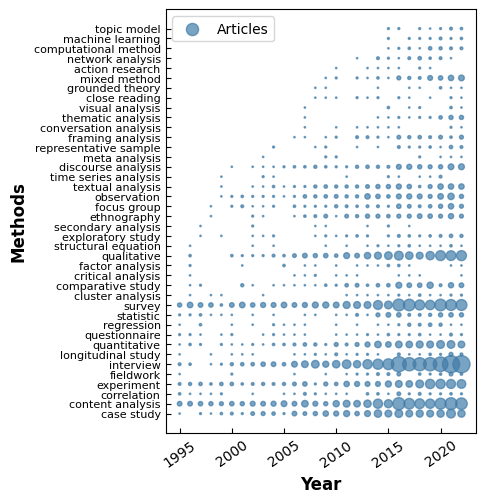

In [186]:
fig, ax=plt.subplots(1, 1, figsize=(4, 5.5))
plt.scatter(b1["date"].to_numpy(), b1.method_detect1.to_numpy(), c='#417ca8', s=b1.counts.to_numpy(), label="Articles", alpha=0.7)
plt.ylabel('Methods', fontsize=12,fontweight='bold')
plt.xlabel('Year', fontsize=12,fontweight='bold')
plt.legend()
plt.xticks(rotation=35, fontsize=10)
plt.yticks(fontsize=8)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
plt.show()

**RQ6**: How are (digital) methods related to the different journalism research clusters❓

In [189]:
ticks=[i.get_text() for i in ax.get_yticklabels()][::-1]

In [190]:
cate=pd.DataFrame()
data["id1"]=[i.replace("https://openalex.org/", "") for i in data.id]
cate['id1']=[index_doi[eval(str(i))] for i in G_co2.nodes()]
cate['Node_id']=[i for i in G_co2.nodes()]
cate['Community']=[G_co2.nodes[i]['community_leiden'] for i,j in G_co2.nodes(data=True)]
cate['Degree']=[G_co2.degree(i) for i in G_co2.nodes()]
cate_node=cate.merge(data,on=['id1'])
cate_node["Community"]=cate_node["Community"] +1
cate_node['docs']=cate_node.coll.apply(lambda x: ' '.join(x))

In [31]:
#cate1["method_detect"]=cate1["method_detect"].apply(lambda x: eval(x))

In [191]:
data3=cate_node.explode("method_detect").reset_index(drop=True)

In [193]:
data2=cate_node[cate_node['method_detect'].str.len() !=0]
print("method detect number: ", len(data2),", " ,"method detect percentage: ", np.round(len(data2)/len(cate_node), 2))

method detect number:  2642 ,  method detect percentage:  0.61


In [194]:
data3=data3.dropna(subset=['method_detect'])

In [ ]:
data3['method_detect1']=data3.method_detect.apply(lambda x: replace(x.strip()) )
a=data3[["Community", "method_detect1", "id1"]]
b=a[a.method_detect1.isin(bg_m)][a.Community.isin(range(11))]

In [200]:
df1=pd.crosstab(  b.method_detect1, b.Community)

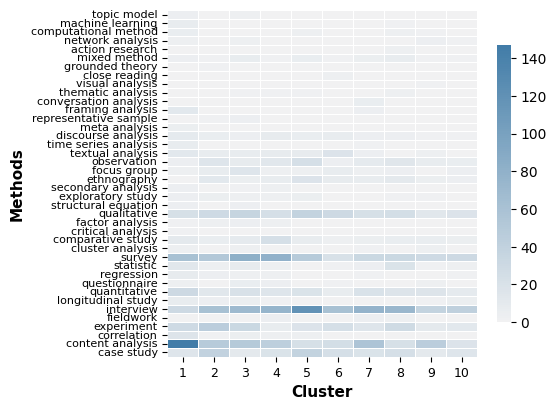

In [204]:
fig, ax=plt.subplots(1, 1, figsize=(5, 4.5))
confusion_matrix=df1.reindex(ticks).to_numpy()
ylabels = ticks
xlabels = list(range(1, 11))
ax=sns.heatmap(confusion_matrix, yticklabels=ylabels, xticklabels=xlabels, linewidths=0.7,center=0, cmap=sns.diverging_palette(240, 240, as_cmap=True), cbar=True,cbar_kws={"shrink": .8})
plt.xlabel('Cluster', fontsize=11,fontweight='bold')
plt.ylabel('Methods', fontsize=11,fontweight='bold')
plt.xticks( fontsize=9)
plt.yticks(fontsize=8)
ax.tick_params(axis="y",direction="out")
ax.tick_params(axis="x",direction="out")


In [ ]:
!jupyter nbconvert Analysis.ipynb --no-input --to html 